In [1]:
# %matplotlib qt
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd
import datetime

In [2]:
# Read serial interval
path = '../data_library/mers/SerialIntervalEstimates-2.csv'
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T
serial_intervals = list(serial_intervals[0])[1:]

In [3]:
# Read MERS data
path = '../data_library/mers/MERSData.csv'
data = pd.read_csv(path)

# Switch the first day data to imported
# This step was performed in the original paper
data.iloc[0, 1] = 0
data.iloc[0, 2] = 1

In [4]:
# R_t inference, same as COVID notebooks
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

locally_infected_cases = data['Incidence Number']
imported_cases = data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

# Same inference, but using the LocImpBranchProPosterior
tau = 27
R_t_start = tau+1
a = 1
b = 0.2

prior_dist = scipy.stats.gamma(a, scale=1/b)
median = prior_dist.median()

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
epsilon_range = [0.25, 0.5, 1.0, 2.0]

all_intervals = pd.DataFrame(columns=column_names)


inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases
    }
)

for epsilon in epsilon_range:
    inference = branchpro.LocImpBranchProPosterior(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_interval=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    intervals['Epsilon'] = [epsilon] * len(intervals.index)

    all_intervals = pd.concat([all_intervals, intervals], ignore_index=True)
    
    
noimport_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases + imported_cases
    }
)
inference = branchpro.BranchProPosterior(
    inc_data=noimport_data,
    daily_serial_interval=serial_intervals,
    alpha=a,
    beta=b)

inference.run_inference(tau=tau)
noimport_intervals = inference.get_intervals(central_prob=.95)


In [5]:
def plot_r_inference(first_day_data,
                     local_cases,
                     import_cases,
                     first_day_inference,
                     epsilons,
                     noimport_R_t_results,
                     R_t_results,
                     prior_mid,
                     epsilon_props,
                     props,
                     default_epsilon=0,
                     show=True):
    """Based on branchpro.figures, with edits for MERS.
    """
    # Build grid of subplots
    fig = plt.figure()
    gs = fig.add_gridspec(4, 2, height_ratios=[10, 10, 10, 10])

    # Ax for case data
    top_ax = fig.add_subplot(gs[0, :])

    # Axes for R_t inference
    axs = [fig.add_subplot(gs[i, j]) for i in [1, 2] for j in [0, 1]]
    
    bottom_ax = fig.add_subplot(gs[-1, :])

    # Make them all share both x and y axis
    axs[1].sharex(axs[0])
    axs[2].sharex(axs[0])
    axs[3].sharex(axs[0])
    axs[1].sharey(axs[0])
    axs[2].sharey(axs[0])
    axs[3].sharey(axs[0])
    axs[0].tick_params(labelbottom=False)
    axs[1].tick_params(labelbottom=False)
    axs[1].tick_params(labelleft=False)
    axs[3].tick_params(labelleft=False)

    # Plot local and imported cases
    width = datetime.timedelta(hours=30)
    data_times = [first_day_data + datetime.timedelta(days=int(i))
                  for i in range(len(local_cases))]
    top_ax.bar([x for x in data_times],
               local_cases,
               width,
               label='Local cases',
               color='k',
               alpha=0.8)
    top_ax.bar([x for x in data_times],
               import_cases,
               width,
               hatch='//',
               edgecolor='w',
               lw=0.1,
               label='Imported cases',
               color='red',
               bottom=local_cases)
    top_ax.legend()

    # Get R_t for the default epsilon
    default_results = noimport_R_t_results

    # Build time vector for all R_t
    times = len(default_results['Mean'])
    date_times = [first_day_inference + datetime.timedelta(days=int(i))
                  for i in range(times)]

    i = 0
    for epsilon, results in zip(epsilons, R_t_results):
        if epsilon != default_epsilon:
            ax = axs[i]

            # Plot shaded region for R_t
            line, = ax.plot(date_times,
                            results['Mean'],
                            color='red',
                            lw=1.0,
                            zorder=7)
            shade = ax.fill_between(date_times,
                                    results['Lower bound CI'],
                                    results['Upper bound CI'],
                                    alpha=0.3,
                                    color='red',
                                    zorder=6,
                                    linewidth=0.0)

            # Plot another region for the default epsilon inference results
            zeroline, = ax.plot(date_times,
                                default_results['Mean'],
                                color='k',
                                lw=1.0,
                                ls='--',
                                zorder=10)
            zerorange = ax.fill_between(date_times,
                                        default_results['Lower bound CI'],
                                        default_results['Upper bound CI'],
                                        alpha=0.35,
                                        color='k',
                                        zorder=-10,
                                        linewidth=0.0)
                
            diff_pts = [[None, None]]
            for j in range(len(date_times)):
                if results['Mean'].values[j] < 1 and default_results['Mean'].values[j] > 1:
                    if diff_pts[-1][0] is None:
                        diff_pts[-1] = [j, j]
                    else:
                        diff_pts[-1][1] = j
                else:
                    if diff_pts[-1] != [None, None]:
                        diff_pts.append([None, None])
                        
            for (x1, x2) in diff_pts[:-1]:
                ax.axvspan(date_times[x1], date_times[x2]+datetime.timedelta(hours=12), alpha=0.2, color='royalblue', lw=0)
                    
            
            # Add a texture to the region for default epsilon R_t
            zerorangelines = ax.fill_between(
                date_times,
                default_results['Lower bound CI'],
                default_results['Upper bound CI'],
                alpha=1.0,
                color=None,
                facecolor='none',
                zorder=5,
                hatch='||||',
                edgecolor='w',
                linewidth=0)

            # Add labels if the subplot is on the left side of the figure
            if i == 0 or i == 2:
                ax.set_ylabel(r'$R_t^\mathrm{local}$')

            # Add a dotted line for the prior median
            prior_line = ax.axhline(1.0,
                                    color='k',
                                    zorder=-20,
                                    ls=':',
                                    lw=2)

            # Add the legend for this epsilon
            ax.legend([(line, shade), ], [r'$ϵ={}$'.format(epsilon), ])

            if i == 0:
                # Add the legend with prior median and default epsilon
                fig.legend([prior_line, (zerorange, zerorangelines, zeroline)],
                           ['R=1', 'No imported'.format(default_epsilon)],
                           bbox_to_anchor=(0.72, 0.75),
                           ncol=2)

            i += 1

            
    bottom_ax.plot(epsilon_props, props, color='k')
    bottom_ax.set_xlabel(r'$ϵ$')
    bottom_ax.set_ylabel(r'Proportion of time $R_t^\mathrm{local}<1$' + '\n' + r'and $R_t^\mathrm{no imports}>1$')
    
    # Use "Jan 01", etc as the date format
    top_ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))

    # Set ticks once per 4 weeks
    ax.set_xticks(date_times[::56])
    top_ax.set_xticks(data_times[::28])

    # Rotate labels
    plt.xticks(rotation=45, ha='center')
    plt.sca(axs[3])
    plt.xticks(rotation=45, ha='center')
    plt.sca(axs[2])
    plt.xticks(rotation=45, ha='center')

    plt.sca(top_ax)
    plt.xticks(rotation=45, ha='center')
    
    # Add panel labels
    fig.text(0.025, 0.975, '(a)', fontsize=14)
    fig.text(0.025, 0.73, '(b)', fontsize=14)
    fig.text(0.025, 0.28, '(c)', fontsize=14)
    
    fig.set_size_inches(8, 9)
    fig.set_tight_layout(True)

    if show:
        plt.show()

    return fig

In [6]:
# Run the inference at a finer grid of epsilons
# For each epsilon, get the proportion of time R_t is inferred 
# differently (below 1 with epsilon, above 1 without considering imported)

epsilon_range2 = np.linspace(0.25, 2.0, 100)
props = []

noimport_above_one = noimport_intervals['Mean'] > 1

for epsilon in epsilon_range2:
    inference = branchpro.LocImpBranchProPosterior(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_interval=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    with_epsilon_below_one = intervals['Mean'] < 1
    
    prop = sum(np.logical_and(with_epsilon_below_one, noimport_above_one)) / len(noimport_above_one)
    props.append(prop)

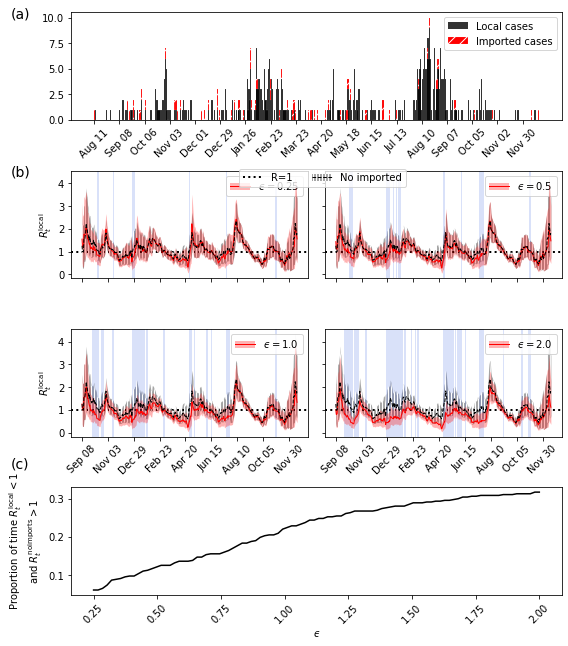

In [7]:
fig = plot_r_inference(
    datetime.datetime(2014, 8, 11),
    locally_infected_cases,
    imported_cases,
    datetime.datetime(2014, 8, 11) + datetime.timedelta(days=28),
    epsilon_range,
    noimport_intervals,
    [all_intervals.loc[all_intervals['Epsilon'] == e]
        for e in epsilon_range],
    median,
    epsilon_range2,
    props,
    default_epsilon=math.nan,
    show=False)